# Import libraries

In [3]:
!python -m nltk.downloader stopwords

^C


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import string
import pandas as pd
import numpy as np
import re
import joblib
import pickle
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
df=pd.read_csv("News Detections_Training Part.csv")

# Cleaning the Dataset

In [7]:
df.drop(columns=['news_reply','news_url','source_domain'],inplace=True)


In [8]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16999 rows x 2 columns]

# Handling Duplicated Values

In [9]:
df.duplicated().sum()

817

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

0

In [12]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16182 rows x 2 columns]

In [13]:
df.isnull()

real   news
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
16994  False  False
16995  False  False
16996  False  False
16997  False  False
16998  False  False

[16182 rows x 2 columns]

In [14]:
df.isnull().sum()

real    0
news    0
dtype: int64

In [15]:
df.describe()

real
count  16182.000000
mean       0.758126
std        0.428231
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

## Text Cleaning

In [16]:
STOP_WORDS = set(stopwords.words("english"))

LEMMATIZER = WordNetLemmatizer()


def clean_mentions(text: str):
    return re.sub(r"@[a-zA-Z0-9_]+", "", text)


def clean_URLs(text: str):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)


def clean_HTML5_entities(text: str):
    return re.sub(r"&[a-z]+;", "", text)


def clean_punctuations(text: str):
    return re.sub(r"\W", " ", text)


def clean_numbers(text: str):
    return re.sub(r"[0-9]+", "", text)


def clean_stopwords(text: str):
    return " ".join([token for token in text.split() if token not in STOP_WORDS])


def lemmatize_text(text: str):
    return " ".join([LEMMATIZER.lemmatize(token, pos="v") for token in text.split()])


def normalize(text: str):
    text = text.lower()
    text = clean_mentions(text)
    text = clean_URLs(text)
    text = clean_HTML5_entities(text)
    text = clean_punctuations(text)
    text = clean_numbers(text)
    text = clean_stopwords(text)
    text = lemmatize_text(text)
    return text

In [17]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
df["news"] = df["news"].apply(str.lower)
df['news'] = df['news'].apply(clean_URLs)
df['news'] = df['news'].apply(clean_HTML5_entities)
df['news'] = df['news'].apply(clean_numbers)
df['news'] = df['news'].apply(clean_stopwords)
df['news'] = df['news'].apply(clean_punctuations)
df["news"] = df["news"].apply(lemmatize_text)
display(df['news'])

0        kandi burruss explode rape accusation real hou...
1               people s choice award best red carpet look
2        sophia bush send sweet birthday message one tr...
3        colombian singer maluma spark rumour inappropr...
4        gossip girl years later upper east siders shoc...
                               ...                        
16994             amber rise become unlikely feminist icon
16995     rihanna cradle newborn baby love twitter picture
16996    kourtney kardashian younes bendjima make paris...
16997        emmy award elisabeth moss find nomination gif
16998            jason aldean gig cancel sell liberals snl
Name: news, Length: 16182, dtype: object

# Vectorize The Text

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Max words
tfidf_features = tfidf_vectorizer.fit_transform(df['news'])

## Spliting the data

In [20]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_features, df['real'], test_size=0.2, random_state=42) # x,y

## Model Training

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust parameters as needed
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

## Model Accuracy

In [22]:
y_pred = rf_model.predict(x_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.8186592523941921


# Confusion Matrix and Accuracy

Confusion Matrix:
[[ 378  410]
 [ 177 2272]]


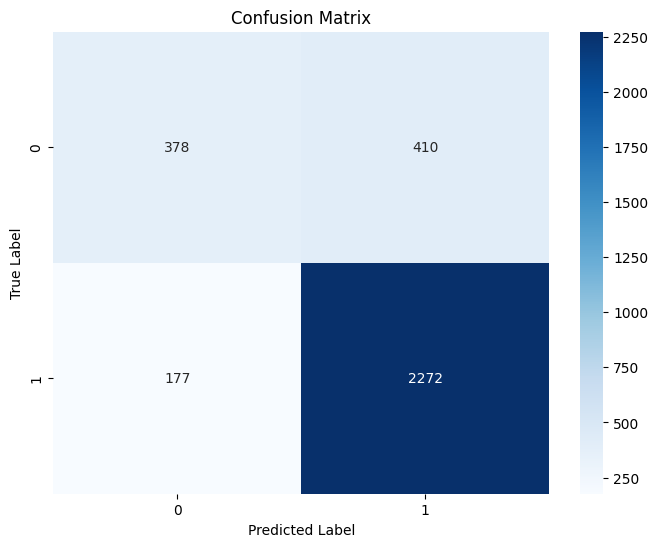

Accuracy: 0.8186592523941921


In [23]:
# Step 1: Confusion Matrix and Accuracy
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)

# Cross Validation

In [24]:
# Cross-Validation
cv_scores = cross_val_score(rf_model, tfidf_features, df['real'], cv=5)  # 5-fold cross-validation
print("Cross-Validation Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Mean Accuracy: 0.812878422504318


#Grid Search

In [26]:
# Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, verbose=3)
grid_search.fit(x_train, y_train)
print("Best Parameters (Grid Search):", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.806 total time=  10.4s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.817 total time=   9.9s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.806 total time=   8.5s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.809 total time=   7.9s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.805 total time=   7.8s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.805 total time=  16.6s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.819 total time=  16.7s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.812 to

# Random Search

In [ ]:
# Random Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_search = RandomizedSearchCV(rf_model, param_dist, cv=5, n_iter=10, random_state=42, verbose=3)
random_search.fit(x_train, y_train)
print("Best Parameters (Random Search):", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.760 total time=   0.3s
[CV 2/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.767 total time=   0.4s
[CV 3/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.763 total time=   0.5s
[CV 4/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.762 total time=   0.4s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.761 total time=   0.6s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.806 total time=   9.1s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.817 total time=   5.6s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.806 total time=   6.

In [27]:
# Step 2: Precision, Recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.48      0.56       788
           1       0.85      0.93      0.89      2449

    accuracy                           0.82      3237
   macro avg       0.76      0.70      0.72      3237
weighted avg       0.81      0.82      0.81      3237



## Process User Input and Predict

In [28]:
def preprocess_input(text):
    cleaned_text = normalize(text)
    transformed_text = tfidf_vectorizer.transform([cleaned_text]).toarray()
    return transformed_text

def predict_real_or_fake(text):
    transformed_text = preprocess_input(text)
    prediction = rf_model.predict(transformed_text) # change dt_model to rf_model to using  RandomForestClassifier
    real_or_fake_mapping = {0: 'fake', 1: 'real'}
    real_or_fake = real_or_fake_mapping[prediction[0]]
    return real_or_fake

## Test with User Input

In [29]:
text = "Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)"
real_or_fake = predict_real_or_fake(text)
print(f"Text: '{text}'")
print(f"Predicted Real or Fake: {real_or_fake}")

Text: 'Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)'
Predicted Real or Fake: real


# save the model

In [30]:
joblib.dump(rf_model, "real_or_fake_model.rondomForest")

['real_or_fake_model.rondomForest']

In [31]:
with open('real_or_fake_model.rondomForest','wb') as f:
  pickle.dump(rf_model,f)